<a href="https://colab.research.google.com/github/yee030/Speech-command/blob/main/speech_command_classification_with_torchaudio_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inlinel

KeyError: ignored

In [ ]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch # torch: PyTorch 라이브러리
import torch.nn as nn # nn: 신경망 모델을 정의하기 위한 PyTorch의 모듈
import torch.nn.functional as F # F: PyTorch의 함수 모듈
import torch.optim as optim # optim: 옵티마이저를 정의하기 위한 PyTorch의 모듈
import torchaudio # torchaudio: 오디오 처리를 위한 라이브러리
import sys # sys: 시스템 관련 기능을 제공하는 파이썬 모듈

import matplotlib.pyplot as plt # matplotlib.pyplot: 그래프를 그리기 위한 라이브러리
import IPython.display as ipd # IPython.display: 오디오 재생을 위한 라이브러리

from tqdm import tqdm # tqdm: 훈련 및 데이터 로딩 진행 상황을 시각적으로 표시하기 위한 라이브러리

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

# SubsetSC 클래스 정의
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        # 상위 클래스 SPEECHCOMMANDS의 생성자 호출
        super().__init__("./", download=True)

        # 파일에서 목록을 로드하는 함수 정의
        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        # subset에 따라 데이터셋 생성
        if subset == "validation":
            # "validation_list.txt" 파일에서 읽은 목록을 사용하여 검증 데이터셋 생성
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            # "testing_list.txt" 파일에서 읽은 목록을 사용하여 테스트 데이터셋 생성
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            # 훈련 데이터셋 생성, 검증 데이터셋과 테스트 데이터셋 목록을 로드하고 이를 제외한 데이터만 사용
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

# 데이터셋 생성: 훈련 데이터셋과 테스트 데이터셋을 만듭니다.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

# 훈련 데이터셋에서 첫 번째 데이터를 가져옵니다.
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]


Waveform의 형태: torch.Size([1, 16000])
Waveform의 샘플 레이트: 16000


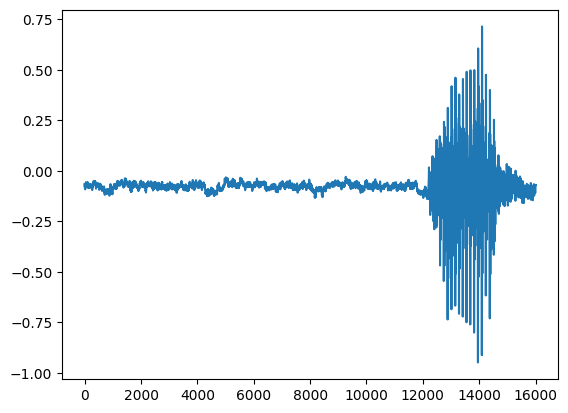

In [ ]:

# 웨이브폼의 모양 출력
print("Waveform의 형태: {}".format(waveform.size()))

# 웨이브폼의 샘플 레이트 출력
print("Waveform의 샘플 레이트: {}".format(sample_rate))

# 웨이브폼을 그래프로 그립니다.
plt.plot(waveform.t().numpy())


In [ ]:
# train_set에서 데이터 포인트의 레이블을 중복을 제거하여 추출하고, 알파벳 순서로 정렬한 리스트를 생성합니다.
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))


In [ ]:
# 첫 번째 데이터 포인트의 오디오 웨이브폼을 추출합니다.
waveform_first, *_ = train_set[0]

# ipd.Audio() 함수를 사용하여 waveform_first의 오디오를 듣습니다.
# rate=sample_rate는 샘플 레이트를 설정하는 인자로, sample_rate 변수의 값인 16,000으로 설정됩니다.
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

# 두 번째 데이터 포인트의 오디오 웨이브폼을 추출합니다.
waveform_second, *_ = train_set[1]

# ipd.Audio() 함수를 사용하여 waveform_second의 오디오를 듣습니다.
# rate=sample_rate는 샘플 레이트를 설정하는 인자로, sample_rate 변수의 값인 16,000으로 설정됩니다.
ipd.Audio(waveform_second.numpy(), rate=sample_rate)


In [ ]:
# 훈련 데이터셋에서 마지막 데이터 포인트를 가져옵니다. -1은 마지막 데이터 포인트를 의미합니다.
waveform_last, *_ = train_set[-1]

# ipd.Audio() 함수를 사용하여 waveform_last의 오디오를 듣습니다.
# rate=sample_rate는 샘플 레이트를 설정하는 인자로, sample_rate 변수의 값인 16,000으로 설정됩니다.
ipd.Audio(waveform_last.numpy(), rate=sample_rate)


In [ ]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
# 다운샘플링된 결과를 적용하여 웨이브폼을 변환합니다.
transformed = transform(waveform)

# GPU로 데이터를 다시 옮깁니다.
transformed = transformed.to(device)

# 원본 웨이브폼도 GPU로 옮깁니다.
waveform = waveform.to(device)

# ipd.Audio() 함수를 사용하여 변환된 웨이브폼을 듣습니다.
# rate=new_sample_rate는 새로운 샘플 레이트를 설정하는 인자로, new_sample_rate 변수의 값인 8000으로 설정됩니다.
ipd.Audio(transformed.cpu().numpy(), rate=new_sample_rate)


RuntimeError: ignored

In [ ]:
# 레이블을 인덱스로 변환하는 함수 정의
def label_to_index(word):
    # labels 리스트에서 입력된 단어(word)의 위치(인덱스)를 반환합니다.
    return torch.tensor(labels.index(word))

# 인덱스를 레이블로 변환하는 함수 정의
def index_to_label(index):
    # labels 리스트에서 입력된 인덱스에 해당하는 단어를 반환합니다.
    # 이 함수는 label_to_index 함수의 역함수 역할을 합니다.
    return labels[index]

# 변환을 테스트할 단어(word_start) 설정
word_start = "yes"

# label_to_index 함수를 사용하여 단어를 인덱스로 변환
index = label_to_index(word_start)

# index_to_label 함수를 사용하여 인덱스를 다시 레이블로 변환
word_recovered = index_to_label(index)

# 결과 출력: 원래 단어, 변환된 인덱스, 다시 복원된 단어
print(word_start, "-->", index, "-->", word_recovered)


yes --> tensor(33) --> yes


In [ ]:
# 모든 텐서를 동일한 길이로 만들기 위해 제로 패딩을 사용하여 배치 내의 모든 텐서를 패딩합니다.
def pad_sequence(batch):
    batch = [item.t() for item in batch]  # 각 텐서를 전치하여 차원을 조정합니다.
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)  # 패딩을 적용합니다.
    return batch.permute(0, 2, 1)  # 텐서의 차원을 재배열합니다.

# 데이터 포인트를 배치로 묶는 collate 함수 정의
def collate_fn(batch):
    tensors, targets = [], []

    # 데이터 포인트는 다음과 같은 형태를 가집니다:
    # waveform, sample_rate, label, speaker_id, utterance_number

    # 리스트에 데이터를 모으고 레이블을 인덱스로 인코딩합니다.
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]  # 레이블을 인덱스로 변환하여 저장합니다.

    # 텐서 리스트를 배치로 묶습니다.
    tensors = pad_sequence(tensors)  # 패딩된 텐서를 생성합니다.
    targets = torch.stack(targets)  # 레이블 인덱스를 스택하여 텐서로 만듭니다.

    return tensors, targets

# 배치 크기 설정
batch_size = 256

# GPU를 사용하는 경우, 데이터 로딩에 사용할 워커 수와 메모리 핀(pinning) 설정을 조정합니다.
if device == "cuda":
    num_workers = 1  # 워커 수를 조정하여 병렬 처리를 활용합니다.
    pin_memory = True  # 메모리 핀을 활성화하여 데이터 전송 속도를 높입니다.
else:
    num_workers = 0  # CPU에서는 워커를 사용하지 않습니다.
    pin_memory = False

# 훈련 데이터 로더와 테스트 데이터 로더 생성
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,  # 훈련 데이터를 무작위로 섞습니다.
    collate_fn=collate_fn,  # collate 함수를 사용하여 데이터를 배치로 묶습니다.
    num_workers=num_workers,  # 워커 수 설정
    pin_memory=pin_memory,  # 메모리 핀 설정
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,  # 테스트 데이터를 섞지 않습니다.
    drop_last=False,  # 마지막 배치를 버리지 않습니다.
    collate_fn=collate_fn,  # collate 함수를 사용하여 데이터를 배치로 묶습니다.
    num_workers=num_workers,  # 워커 수 설정
    pin_memory=pin_memory,  # 메모리 핀 설정
)


In [ ]:
# M5 모델 클래스 정의
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        # Convolutional 레이어 1
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        # Convolutional 레이어 2
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        # Convolutional 레이어 3
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        # Convolutional 레이어 4
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        # Fully Connected 레이어
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        # 순전파 메서드 정의
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

# 모델 인스턴스 생성 및 디바이스로 이동
model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)

# 모델 파라미터 수 계산 및 출력
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n = count_parameters(model)
print("Number of parameters: %s" % n)


M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

In [ ]:
# Adam 옵티마이저를 사용하여 모델 파라미터를 최적화하며, 학습률 및 가중치 감소를 설정합니다.
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)

# 학습률을 조절하기 위한 스케줄러를 설정합니다.
# step_size는 주기적으로 학습률을 감소시킬 에포크 간격을 설정하고, gamma는 감소율을 나타냅니다.
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)


In [ ]:
def train(model, epoch, log_interval):
    model.train()  # 모델을 훈련 모드로 설정합니다.

    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # 데이터에 변환을 적용하고 모델에 직접 전체 배치를 디바이스로 전달합니다.
        data = transform(data)  # 데이터에 변환을 적용합니다.
        output = model(data)  # 모델에 데이터를 전달하여 출력을 얻습니다.

        # 크기가 (batch x 1 x n_output)인 텐서에 대한 음의 로그 우도(negative log-likelihood) 계산
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()  # 그래디언트 초기화
        loss.backward()  # 역전파를 수행하여 그래디언트 계산
        optimizer.step()  # 옵티마이저를 사용하여 모델 파라미터 업데이트

        # 훈련 정보 출력
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # 프로그래스 바 업데이트
        pbar.update(pbar_update)
        # 손실 기록
        losses.append(loss.item())


In [ ]:
def number_of_correct(pred, target):
    # 올바른 예측 수를 세는 함수
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor):
    # 각 배치 요소에서 가장 가능성 높은 레이블 인덱스를 찾는 함수
    return tensor.argmax(dim=-1)

def test(model, epoch):
    model.eval()  # 모델을 평가(eval) 모드로 설정합니다.
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # 데이터에 변환을 적용하고 모델에 직접 전체 배치를 디바이스로 전달합니다.
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)  # 예측 결과에서 가장 가능성 높은 레이블 인덱스를 얻습니다.
        correct += number_of_correct(pred, target)  # 정확한 예측 수를 누적합니다.

        # 프로그래스 바 업데이트
        pbar.update(pbar_update)

    # 정확도 출력
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")


In [ ]:
log_interval = 0.5  # 로그를 출력할 에포크 간격 설정
n_epoch = 1  # 총 에포크 수 설정

pbar_update = 1 / (len(train_loader) + len(test_loader))  # 프로그래스 바 업데이트 간격 설정
losses = []  # 훈련 중 발생한 손실을 기록하기 위한 리스트

# 변환(transform)은 모델과 데이터와 동일한 디바이스에 있어야 합니다.
transform = transform.to(device)

# tqdm을 사용하여 에포크의 진행 상황을 시각적으로 표시합니다.
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        # 훈련 함수를 호출하여 모델 훈련
        train(model, epoch, log_interval)
        # 테스트 함수를 호출하여 모델 테스트
        test(model, epoch)
        # 스케줄러를 사용하여 학습률 조정
        scheduler.step()

# 훈련 손실을 반복 횟수에 대한 그래프로 시각화합니다.
# plt.plot(losses);
# plt.title("training loss");


  1%|          | 0.005333333333333333/1 [00:00<01:12, 73.12s/it] 

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.582275
Train Epoch: 1 [256/84843 (0%)]	Loss: 3.536537


  1%|          | 0.008/1 [00:00<01:05, 66.50s/it]               

Train Epoch: 1 [512/84843 (1%)]	Loss: 3.514812


  1%|▏         | 0.013333333333333332/1 [00:00<01:09, 70.08s/it]

Train Epoch: 1 [768/84843 (1%)]	Loss: 3.493898
Train Epoch: 1 [1024/84843 (1%)]	Loss: 3.437124


  2%|▏         | 0.018666666666666668/1 [00:01<01:01, 63.13s/it]

Train Epoch: 1 [1280/84843 (2%)]	Loss: 3.432719
Train Epoch: 1 [1536/84843 (2%)]	Loss: 3.410922


  2%|▏         | 0.024000000000000004/1 [00:01<00:57, 59.34s/it]

Train Epoch: 1 [1792/84843 (2%)]	Loss: 3.400766
Train Epoch: 1 [2048/84843 (2%)]	Loss: 3.388614


  3%|▎         | 0.02933333333333334/1 [00:01<00:56, 58.14s/it] 

Train Epoch: 1 [2304/84843 (3%)]	Loss: 3.402138
Train Epoch: 1 [2560/84843 (3%)]	Loss: 3.424745


  3%|▎         | 0.03466666666666667/1 [00:02<00:59, 61.76s/it]

Train Epoch: 1 [2816/84843 (3%)]	Loss: 3.331178
Train Epoch: 1 [3072/84843 (4%)]	Loss: 3.371716


  4%|▍         | 0.04/1 [00:02<01:00, 63.25s/it]                

Train Epoch: 1 [3328/84843 (4%)]	Loss: 3.400477
Train Epoch: 1 [3584/84843 (4%)]	Loss: 3.300850


  5%|▍         | 0.04533333333333333/1 [00:02<01:00, 63.87s/it] 

Train Epoch: 1 [3840/84843 (5%)]	Loss: 3.269902
Train Epoch: 1 [4096/84843 (5%)]	Loss: 3.270648


  5%|▌         | 0.05066666666666666/1 [00:03<01:00, 63.38s/it] 

Train Epoch: 1 [4352/84843 (5%)]	Loss: 3.245211
Train Epoch: 1 [4608/84843 (5%)]	Loss: 3.197682


  6%|▌         | 0.05599999999999999/1 [00:03<00:59, 63.23s/it]

Train Epoch: 1 [4864/84843 (6%)]	Loss: 3.121633
Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.176142


  6%|▌         | 0.061333333333333316/1 [00:03<00:59, 63.91s/it]

Train Epoch: 1 [5376/84843 (6%)]	Loss: 3.085536
Train Epoch: 1 [5632/84843 (7%)]	Loss: 3.100826


  7%|▋         | 0.06666666666666665/1 [00:04<01:00, 64.96s/it]

Train Epoch: 1 [5888/84843 (7%)]	Loss: 3.003956
Train Epoch: 1 [6144/84843 (7%)]	Loss: 3.048051


  7%|▋         | 0.07199999999999998/1 [00:04<01:00, 65.02s/it]

Train Epoch: 1 [6400/84843 (8%)]	Loss: 2.925165
Train Epoch: 1 [6656/84843 (8%)]	Loss: 3.065069


  8%|▊         | 0.07733333333333331/1 [00:04<00:56, 61.08s/it]

Train Epoch: 1 [6912/84843 (8%)]	Loss: 3.061783
Train Epoch: 1 [7168/84843 (8%)]	Loss: 2.961550


  8%|▊         | 0.08266666666666664/1 [00:05<00:53, 58.02s/it]

Train Epoch: 1 [7424/84843 (9%)]	Loss: 2.983517
Train Epoch: 1 [7680/84843 (9%)]	Loss: 2.920724


  9%|▉         | 0.08799999999999997/1 [00:05<00:52, 57.13s/it]

Train Epoch: 1 [7936/84843 (9%)]	Loss: 2.855943
Train Epoch: 1 [8192/84843 (10%)]	Loss: 2.873047


  9%|▉         | 0.0933333333333333/1 [00:05<00:51, 56.42s/it] 

Train Epoch: 1 [8448/84843 (10%)]	Loss: 2.845178
Train Epoch: 1 [8704/84843 (10%)]	Loss: 2.889064


 10%|▉         | 0.09866666666666662/1 [00:06<00:50, 56.58s/it]

Train Epoch: 1 [8960/84843 (11%)]	Loss: 2.875492
Train Epoch: 1 [9216/84843 (11%)]	Loss: 2.785254


 10%|█         | 0.10399999999999995/1 [00:06<00:50, 56.28s/it]

Train Epoch: 1 [9472/84843 (11%)]	Loss: 2.829064
Train Epoch: 1 [9728/84843 (11%)]	Loss: 2.943607


 11%|█         | 0.10933333333333328/1 [00:06<00:51, 57.64s/it]

Train Epoch: 1 [9984/84843 (12%)]	Loss: 2.866655
Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.850984


 11%|█▏        | 0.11466666666666661/1 [00:07<00:50, 56.82s/it]

Train Epoch: 1 [10496/84843 (12%)]	Loss: 2.716523
Train Epoch: 1 [10752/84843 (13%)]	Loss: 2.741266


 12%|█▏        | 0.11999999999999994/1 [00:07<00:50, 57.21s/it]

Train Epoch: 1 [11008/84843 (13%)]	Loss: 2.837594
Train Epoch: 1 [11264/84843 (13%)]	Loss: 2.726488


 13%|█▎        | 0.12533333333333327/1 [00:07<00:49, 56.28s/it]

Train Epoch: 1 [11520/84843 (14%)]	Loss: 2.809407
Train Epoch: 1 [11776/84843 (14%)]	Loss: 2.656544


 13%|█▎        | 0.13066666666666663/1 [00:07<00:48, 56.29s/it]

Train Epoch: 1 [12032/84843 (14%)]	Loss: 2.613752
Train Epoch: 1 [12288/84843 (14%)]	Loss: 2.777432


 14%|█▎        | 0.13599999999999998/1 [00:08<00:48, 56.08s/it]

Train Epoch: 1 [12544/84843 (15%)]	Loss: 2.728979
Train Epoch: 1 [12800/84843 (15%)]	Loss: 2.715871


 14%|█▍        | 0.14133333333333334/1 [00:08<00:48, 56.48s/it]

Train Epoch: 1 [13056/84843 (15%)]	Loss: 2.654985
Train Epoch: 1 [13312/84843 (16%)]	Loss: 2.787050


 15%|█▍        | 0.1466666666666667/1 [00:08<00:47, 56.14s/it] 

Train Epoch: 1 [13568/84843 (16%)]	Loss: 2.684498
Train Epoch: 1 [13824/84843 (16%)]	Loss: 2.702235


 15%|█▌        | 0.15200000000000005/1 [00:09<00:47, 55.63s/it]

Train Epoch: 1 [14080/84843 (17%)]	Loss: 2.591359
Train Epoch: 1 [14336/84843 (17%)]	Loss: 2.719482


 16%|█▌        | 0.1573333333333334/1 [00:09<00:47, 55.99s/it] 

Train Epoch: 1 [14592/84843 (17%)]	Loss: 2.637594
Train Epoch: 1 [14848/84843 (17%)]	Loss: 2.602444


 16%|█▋        | 0.16266666666666676/1 [00:09<00:46, 56.03s/it]

Train Epoch: 1 [15104/84843 (18%)]	Loss: 2.527921
Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.669499


 17%|█▋        | 0.16800000000000012/1 [00:10<00:46, 55.92s/it]

Train Epoch: 1 [15616/84843 (18%)]	Loss: 2.683044
Train Epoch: 1 [15872/84843 (19%)]	Loss: 2.469504


 17%|█▋        | 0.17333333333333348/1 [00:10<00:45, 55.56s/it]

Train Epoch: 1 [16128/84843 (19%)]	Loss: 2.558935
Train Epoch: 1 [16384/84843 (19%)]	Loss: 2.566639


 18%|█▊        | 0.17866666666666683/1 [00:10<00:45, 55.74s/it]

Train Epoch: 1 [16640/84843 (20%)]	Loss: 2.539303
Train Epoch: 1 [16896/84843 (20%)]	Loss: 2.514588


 18%|█▊        | 0.1840000000000002/1 [00:10<00:45, 56.32s/it]

Train Epoch: 1 [17152/84843 (20%)]	Loss: 2.700408
Train Epoch: 1 [17408/84843 (20%)]	Loss: 2.488350


 19%|█▉        | 0.18933333333333355/1 [00:11<00:46, 56.93s/it]

Train Epoch: 1 [17664/84843 (21%)]	Loss: 2.492684
Train Epoch: 1 [17920/84843 (21%)]	Loss: 2.491860


 19%|█▉        | 0.1946666666666669/1 [00:11<00:46, 57.51s/it] 

Train Epoch: 1 [18176/84843 (21%)]	Loss: 2.556803
Train Epoch: 1 [18432/84843 (22%)]	Loss: 2.515462


 20%|██        | 0.20000000000000026/1 [00:11<00:45, 57.31s/it]

Train Epoch: 1 [18688/84843 (22%)]	Loss: 2.513478
Train Epoch: 1 [18944/84843 (22%)]	Loss: 2.449432


 21%|██        | 0.20533333333333362/1 [00:12<00:45, 57.45s/it]

Train Epoch: 1 [19200/84843 (23%)]	Loss: 2.460959
Train Epoch: 1 [19456/84843 (23%)]	Loss: 2.541894


 21%|██        | 0.21066666666666697/1 [00:12<00:45, 58.19s/it]

Train Epoch: 1 [19712/84843 (23%)]	Loss: 2.409711
Train Epoch: 1 [19968/84843 (23%)]	Loss: 2.520858


 22%|██▏       | 0.21600000000000033/1 [00:12<00:44, 57.17s/it]

Train Epoch: 1 [20224/84843 (24%)]	Loss: 2.528270
Train Epoch: 1 [20480/84843 (24%)]	Loss: 2.468617


 22%|██▏       | 0.2213333333333337/1 [00:13<00:43, 56.22s/it]

Train Epoch: 1 [20736/84843 (24%)]	Loss: 2.465132
Train Epoch: 1 [20992/84843 (25%)]	Loss: 2.536947


 23%|██▎       | 0.22666666666666704/1 [00:13<00:43, 56.36s/it]

Train Epoch: 1 [21248/84843 (25%)]	Loss: 2.432451
Train Epoch: 1 [21504/84843 (25%)]	Loss: 2.476920


 23%|██▎       | 0.2320000000000004/1 [00:13<00:42, 55.84s/it] 

Train Epoch: 1 [21760/84843 (26%)]	Loss: 2.592155
Train Epoch: 1 [22016/84843 (26%)]	Loss: 2.565209


 24%|██▎       | 0.23733333333333376/1 [00:13<00:42, 56.38s/it]

Train Epoch: 1 [22272/84843 (26%)]	Loss: 2.361819
Train Epoch: 1 [22528/84843 (27%)]	Loss: 2.413141


 24%|██▍       | 0.2426666666666671/1 [00:14<00:43, 57.07s/it] 

Train Epoch: 1 [22784/84843 (27%)]	Loss: 2.331462
Train Epoch: 1 [23040/84843 (27%)]	Loss: 2.340150


 25%|██▍       | 0.24800000000000047/1 [00:14<00:42, 57.14s/it]

Train Epoch: 1 [23296/84843 (27%)]	Loss: 2.431255
Train Epoch: 1 [23552/84843 (28%)]	Loss: 2.386347


 25%|██▌       | 0.2533333333333338/1 [00:14<00:45, 61.33s/it] 

Train Epoch: 1 [23808/84843 (28%)]	Loss: 2.442381
Train Epoch: 1 [24064/84843 (28%)]	Loss: 2.356982


 26%|██▌       | 0.2586666666666671/1 [00:15<00:46, 62.93s/it] 

Train Epoch: 1 [24320/84843 (29%)]	Loss: 2.350708
Train Epoch: 1 [24576/84843 (29%)]	Loss: 2.434067


 26%|██▋       | 0.2640000000000004/1 [00:15<00:46, 63.15s/it] 

Train Epoch: 1 [24832/84843 (29%)]	Loss: 2.461949
Train Epoch: 1 [25088/84843 (30%)]	Loss: 2.472290


 27%|██▋       | 0.2693333333333337/1 [00:15<00:46, 63.78s/it] 

Train Epoch: 1 [25344/84843 (30%)]	Loss: 2.369814
Train Epoch: 1 [25600/84843 (30%)]	Loss: 2.276542


 27%|██▋       | 0.274666666666667/1 [00:16<00:46, 63.68s/it]  

Train Epoch: 1 [25856/84843 (30%)]	Loss: 2.323342
Train Epoch: 1 [26112/84843 (31%)]	Loss: 2.324654


 28%|██▊       | 0.2800000000000003/1 [00:16<00:46, 64.11s/it] 

Train Epoch: 1 [26368/84843 (31%)]	Loss: 2.508404
Train Epoch: 1 [26624/84843 (31%)]	Loss: 2.361910


 29%|██▊       | 0.2853333333333336/1 [00:16<00:45, 63.64s/it] 

Train Epoch: 1 [26880/84843 (32%)]	Loss: 2.385558
Train Epoch: 1 [27136/84843 (32%)]	Loss: 2.260173


 29%|██▉       | 0.2906666666666669/1 [00:17<00:43, 61.59s/it] 

Train Epoch: 1 [27392/84843 (32%)]	Loss: 2.240782
Train Epoch: 1 [27648/84843 (33%)]	Loss: 2.300380


 30%|██▉       | 0.2960000000000002/1 [00:17<00:42, 59.73s/it] 

Train Epoch: 1 [27904/84843 (33%)]	Loss: 2.364257
Train Epoch: 1 [28160/84843 (33%)]	Loss: 2.349538


 30%|███       | 0.3013333333333335/1 [00:17<00:40, 57.66s/it] 

Train Epoch: 1 [28416/84843 (33%)]	Loss: 2.279115
Train Epoch: 1 [28672/84843 (34%)]	Loss: 2.325787


 31%|███       | 0.3066666666666668/1 [00:18<00:39, 57.09s/it] 

Train Epoch: 1 [28928/84843 (34%)]	Loss: 2.331852
Train Epoch: 1 [29184/84843 (34%)]	Loss: 2.376454


 31%|███       | 0.3120000000000001/1 [00:18<00:39, 56.87s/it] 

Train Epoch: 1 [29440/84843 (35%)]	Loss: 2.215026
Train Epoch: 1 [29696/84843 (35%)]	Loss: 2.231150


 32%|███▏      | 0.3173333333333334/1 [00:18<00:39, 57.74s/it] 

Train Epoch: 1 [29952/84843 (35%)]	Loss: 2.405170
Train Epoch: 1 [30208/84843 (36%)]	Loss: 2.318080


 32%|███▏      | 0.3226666666666667/1 [00:19<00:38, 57.05s/it] 

Train Epoch: 1 [30464/84843 (36%)]	Loss: 2.287200
Train Epoch: 1 [30720/84843 (36%)]	Loss: 2.253129


 33%|███▎      | 0.328/1 [00:19<00:37, 56.48s/it]              

Train Epoch: 1 [30976/84843 (36%)]	Loss: 2.141979
Train Epoch: 1 [31232/84843 (37%)]	Loss: 2.249844


 33%|███▎      | 0.3333333333333333/1 [00:19<00:37, 56.42s/it] 

Train Epoch: 1 [31488/84843 (37%)]	Loss: 2.242684
Train Epoch: 1 [31744/84843 (37%)]	Loss: 2.165526


 34%|███▍      | 0.3386666666666666/1 [00:20<00:37, 56.20s/it] 

Train Epoch: 1 [32000/84843 (38%)]	Loss: 2.208769
Train Epoch: 1 [32256/84843 (38%)]	Loss: 2.258621


 34%|███▍      | 0.3439999999999999/1 [00:20<00:36, 55.49s/it] 

Train Epoch: 1 [32512/84843 (38%)]	Loss: 2.188659
Train Epoch: 1 [32768/84843 (39%)]	Loss: 2.140043


 35%|███▍      | 0.3493333333333332/1 [00:20<00:36, 56.35s/it] 

Train Epoch: 1 [33024/84843 (39%)]	Loss: 2.219084
Train Epoch: 1 [33280/84843 (39%)]	Loss: 2.253856


 35%|███▌      | 0.3546666666666665/1 [00:20<00:36, 56.32s/it] 

Train Epoch: 1 [33536/84843 (39%)]	Loss: 2.067170
Train Epoch: 1 [33792/84843 (40%)]	Loss: 2.245144


 36%|███▌      | 0.3599999999999998/1 [00:21<00:36, 56.29s/it] 

Train Epoch: 1 [34048/84843 (40%)]	Loss: 2.194122
Train Epoch: 1 [34304/84843 (40%)]	Loss: 2.088941


 37%|███▋      | 0.3653333333333331/1 [00:21<00:35, 56.05s/it] 

Train Epoch: 1 [34560/84843 (41%)]	Loss: 2.223094
Train Epoch: 1 [34816/84843 (41%)]	Loss: 2.153474


 37%|███▋      | 0.3706666666666664/1 [00:21<00:35, 56.69s/it] 

Train Epoch: 1 [35072/84843 (41%)]	Loss: 2.155421
Train Epoch: 1 [35328/84843 (42%)]	Loss: 2.424235


 38%|███▊      | 0.3759999999999997/1 [00:22<00:35, 56.60s/it]

Train Epoch: 1 [35584/84843 (42%)]	Loss: 2.140841
Train Epoch: 1 [35840/84843 (42%)]	Loss: 2.176698


 38%|███▊      | 0.381333333333333/1 [00:22<00:34, 55.85s/it] 

Train Epoch: 1 [36096/84843 (42%)]	Loss: 2.186249
Train Epoch: 1 [36352/84843 (43%)]	Loss: 2.176092


 39%|███▊      | 0.3866666666666663/1 [00:22<00:34, 56.75s/it]

Train Epoch: 1 [36608/84843 (43%)]	Loss: 2.148817
Train Epoch: 1 [36864/84843 (43%)]	Loss: 2.281944


 39%|███▉      | 0.3919999999999996/1 [00:23<00:34, 56.40s/it]

Train Epoch: 1 [37120/84843 (44%)]	Loss: 2.201396
Train Epoch: 1 [37376/84843 (44%)]	Loss: 2.192288


 40%|███▉      | 0.3973333333333329/1 [00:23<00:33, 55.91s/it]

Train Epoch: 1 [37632/84843 (44%)]	Loss: 2.147348
Train Epoch: 1 [37888/84843 (45%)]	Loss: 2.115493


 40%|████      | 0.40266666666666623/1 [00:23<00:33, 56.18s/it]

Train Epoch: 1 [38144/84843 (45%)]	Loss: 2.359092
Train Epoch: 1 [38400/84843 (45%)]	Loss: 2.245271


 41%|████      | 0.40799999999999953/1 [00:23<00:33, 55.88s/it]

Train Epoch: 1 [38656/84843 (45%)]	Loss: 2.318928
Train Epoch: 1 [38912/84843 (46%)]	Loss: 2.099176


 41%|████▏     | 0.41333333333333283/1 [00:24<00:33, 56.58s/it]

Train Epoch: 1 [39168/84843 (46%)]	Loss: 2.080614
Train Epoch: 1 [39424/84843 (46%)]	Loss: 1.961195


 42%|████▏     | 0.41866666666666613/1 [00:24<00:32, 56.34s/it]

Train Epoch: 1 [39680/84843 (47%)]	Loss: 2.063925
Train Epoch: 1 [39936/84843 (47%)]	Loss: 2.228961


 42%|████▏     | 0.42399999999999943/1 [00:24<00:32, 56.40s/it]

Train Epoch: 1 [40192/84843 (47%)]	Loss: 2.206284
Train Epoch: 1 [40448/84843 (48%)]	Loss: 2.032958


 43%|████▎     | 0.42933333333333273/1 [00:25<00:32, 57.29s/it]

Train Epoch: 1 [40704/84843 (48%)]	Loss: 2.067742
Train Epoch: 1 [40960/84843 (48%)]	Loss: 2.077381


 43%|████▎     | 0.43466666666666604/1 [00:25<00:32, 56.76s/it]

Train Epoch: 1 [41216/84843 (48%)]	Loss: 2.290418
Train Epoch: 1 [41472/84843 (49%)]	Loss: 2.173467


 44%|████▍     | 0.43999999999999934/1 [00:25<00:32, 57.49s/it]

Train Epoch: 1 [41728/84843 (49%)]	Loss: 2.322052
Train Epoch: 1 [41984/84843 (49%)]	Loss: 2.193979


 45%|████▍     | 0.44533333333333264/1 [00:26<00:31, 56.61s/it]

Train Epoch: 1 [42240/84843 (50%)]	Loss: 2.036558
Train Epoch: 1 [42496/84843 (50%)]	Loss: 2.293958


 45%|████▌     | 0.45066666666666594/1 [00:26<00:30, 56.07s/it]

Train Epoch: 1 [42752/84843 (50%)]	Loss: 2.025577
Train Epoch: 1 [43008/84843 (51%)]	Loss: 2.184158


 46%|████▌     | 0.45599999999999924/1 [00:26<00:30, 56.06s/it]

Train Epoch: 1 [43264/84843 (51%)]	Loss: 2.248419
Train Epoch: 1 [43520/84843 (51%)]	Loss: 2.177139


 46%|████▌     | 0.46133333333333254/1 [00:26<00:30, 56.68s/it]

Train Epoch: 1 [43776/84843 (52%)]	Loss: 2.150718
Train Epoch: 1 [44032/84843 (52%)]	Loss: 2.176909


 47%|████▋     | 0.46666666666666584/1 [00:27<00:31, 59.34s/it]

Train Epoch: 1 [44288/84843 (52%)]	Loss: 2.019463
Train Epoch: 1 [44544/84843 (52%)]	Loss: 2.166717


 47%|████▋     | 0.47199999999999914/1 [00:27<00:32, 62.38s/it]

Train Epoch: 1 [44800/84843 (53%)]	Loss: 2.236861
Train Epoch: 1 [45056/84843 (53%)]	Loss: 2.141885


 48%|████▊     | 0.47733333333333244/1 [00:27<00:32, 62.89s/it]

Train Epoch: 1 [45312/84843 (53%)]	Loss: 2.006134
Train Epoch: 1 [45568/84843 (54%)]	Loss: 2.000114


 48%|████▊     | 0.48266666666666574/1 [00:28<00:32, 62.55s/it]

Train Epoch: 1 [45824/84843 (54%)]	Loss: 2.025735
Train Epoch: 1 [46080/84843 (54%)]	Loss: 2.068197


 49%|████▉     | 0.48799999999999905/1 [00:28<00:32, 62.80s/it]

Train Epoch: 1 [46336/84843 (55%)]	Loss: 2.080885
Train Epoch: 1 [46592/84843 (55%)]	Loss: 2.073801


 49%|████▉     | 0.49333333333333235/1 [00:28<00:31, 63.00s/it]

Train Epoch: 1 [46848/84843 (55%)]	Loss: 2.248405
Train Epoch: 1 [47104/84843 (55%)]	Loss: 2.121691


 50%|████▉     | 0.49866666666666565/1 [00:29<00:32, 64.34s/it]

Train Epoch: 1 [47360/84843 (56%)]	Loss: 1.921155
Train Epoch: 1 [47616/84843 (56%)]	Loss: 2.076254


 50%|█████     | 0.503999999999999/1 [00:29<00:31, 64.44s/it] 

Train Epoch: 1 [47872/84843 (56%)]	Loss: 2.051216
Train Epoch: 1 [48128/84843 (57%)]	Loss: 2.120195


 51%|█████     | 0.5093333333333324/1 [00:29<00:29, 61.01s/it]

Train Epoch: 1 [48384/84843 (57%)]	Loss: 2.142796
Train Epoch: 1 [48640/84843 (57%)]	Loss: 2.157871


 51%|█████▏    | 0.5146666666666658/1 [00:30<00:28, 58.58s/it]

Train Epoch: 1 [48896/84843 (58%)]	Loss: 1.936000
Train Epoch: 1 [49152/84843 (58%)]	Loss: 2.089653


 52%|█████▏    | 0.5199999999999992/1 [00:30<00:27, 57.05s/it]

Train Epoch: 1 [49408/84843 (58%)]	Loss: 1.974402
Train Epoch: 1 [49664/84843 (58%)]	Loss: 2.080362


 53%|█████▎    | 0.5253333333333327/1 [00:30<00:26, 56.30s/it]

Train Epoch: 1 [49920/84843 (59%)]	Loss: 2.180789
Train Epoch: 1 [50176/84843 (59%)]	Loss: 2.218131


 53%|█████▎    | 0.5306666666666661/1 [00:31<00:26, 56.53s/it]

Train Epoch: 1 [50432/84843 (59%)]	Loss: 2.101006
Train Epoch: 1 [50688/84843 (60%)]	Loss: 2.182525


 54%|█████▎    | 0.5359999999999995/1 [00:31<00:26, 56.92s/it]

Train Epoch: 1 [50944/84843 (60%)]	Loss: 2.012056
Train Epoch: 1 [51200/84843 (60%)]	Loss: 2.134041


 54%|█████▍    | 0.5413333333333329/1 [00:31<00:25, 56.57s/it]

Train Epoch: 1 [51456/84843 (61%)]	Loss: 2.067265
Train Epoch: 1 [51712/84843 (61%)]	Loss: 2.007674


 55%|█████▍    | 0.5466666666666663/1 [00:32<00:25, 57.25s/it]

Train Epoch: 1 [51968/84843 (61%)]	Loss: 2.044195
Train Epoch: 1 [52224/84843 (61%)]	Loss: 2.195631


 55%|█████▌    | 0.5519999999999997/1 [00:32<00:25, 56.38s/it]

Train Epoch: 1 [52480/84843 (62%)]	Loss: 2.046988
Train Epoch: 1 [52736/84843 (62%)]	Loss: 1.902262


 56%|█████▌    | 0.5573333333333331/1 [00:32<00:24, 56.09s/it]

Train Epoch: 1 [52992/84843 (62%)]	Loss: 2.118135
Train Epoch: 1 [53248/84843 (63%)]	Loss: 2.102572


 56%|█████▋    | 0.5626666666666665/1 [00:32<00:24, 56.56s/it]

Train Epoch: 1 [53504/84843 (63%)]	Loss: 2.070911
Train Epoch: 1 [53760/84843 (63%)]	Loss: 2.000661


 57%|█████▋    | 0.568/1 [00:33<00:24, 57.80s/it]             

Train Epoch: 1 [54016/84843 (64%)]	Loss: 1.867090
Train Epoch: 1 [54272/84843 (64%)]	Loss: 2.130058


 57%|█████▋    | 0.5733333333333334/1 [00:33<00:24, 57.21s/it]

Train Epoch: 1 [54528/84843 (64%)]	Loss: 1.963988
Train Epoch: 1 [54784/84843 (64%)]	Loss: 1.813975


 58%|█████▊    | 0.5786666666666668/1 [00:33<00:24, 58.31s/it]

Train Epoch: 1 [55040/84843 (65%)]	Loss: 1.976747
Train Epoch: 1 [55296/84843 (65%)]	Loss: 2.107960


 58%|█████▊    | 0.5840000000000002/1 [00:34<00:24, 58.57s/it]

Train Epoch: 1 [55552/84843 (65%)]	Loss: 1.987245
Train Epoch: 1 [55808/84843 (66%)]	Loss: 2.078176


 59%|█████▉    | 0.5893333333333336/1 [00:34<00:23, 58.28s/it]

Train Epoch: 1 [56064/84843 (66%)]	Loss: 2.125799
Train Epoch: 1 [56320/84843 (66%)]	Loss: 2.124971


 59%|█████▉    | 0.594666666666667/1 [00:34<00:23, 57.79s/it] 

Train Epoch: 1 [56576/84843 (67%)]	Loss: 2.132864
Train Epoch: 1 [56832/84843 (67%)]	Loss: 2.094791


 60%|██████    | 0.6000000000000004/1 [00:35<00:23, 57.59s/it]

Train Epoch: 1 [57088/84843 (67%)]	Loss: 1.909754
Train Epoch: 1 [57344/84843 (67%)]	Loss: 2.046859


 61%|██████    | 0.6053333333333338/1 [00:35<00:22, 57.22s/it]

Train Epoch: 1 [57600/84843 (68%)]	Loss: 1.975472
Train Epoch: 1 [57856/84843 (68%)]	Loss: 1.994529


 61%|██████    | 0.6106666666666672/1 [00:35<00:22, 57.30s/it]

Train Epoch: 1 [58112/84843 (68%)]	Loss: 2.145934
Train Epoch: 1 [58368/84843 (69%)]	Loss: 1.943506


 62%|██████▏   | 0.6160000000000007/1 [00:36<00:22, 58.21s/it]

Train Epoch: 1 [58624/84843 (69%)]	Loss: 1.849857
Train Epoch: 1 [58880/84843 (69%)]	Loss: 1.858649


 62%|██████▏   | 0.6213333333333341/1 [00:36<00:21, 57.64s/it]

Train Epoch: 1 [59136/84843 (70%)]	Loss: 1.961094
Train Epoch: 1 [59392/84843 (70%)]	Loss: 2.048410


 63%|██████▎   | 0.6266666666666675/1 [00:36<00:21, 57.23s/it]

Train Epoch: 1 [59648/84843 (70%)]	Loss: 1.901332
Train Epoch: 1 [59904/84843 (70%)]	Loss: 2.068422


 63%|██████▎   | 0.6320000000000009/1 [00:36<00:21, 57.21s/it]

Train Epoch: 1 [60160/84843 (71%)]	Loss: 1.946486
Train Epoch: 1 [60416/84843 (71%)]	Loss: 1.832476


 64%|██████▎   | 0.6373333333333343/1 [00:37<00:20, 56.75s/it]

Train Epoch: 1 [60672/84843 (71%)]	Loss: 1.846519
Train Epoch: 1 [60928/84843 (72%)]	Loss: 1.953188


 64%|██████▍   | 0.6426666666666677/1 [00:37<00:20, 56.16s/it]

Train Epoch: 1 [61184/84843 (72%)]	Loss: 1.864305
Train Epoch: 1 [61440/84843 (72%)]	Loss: 2.013177


 65%|██████▍   | 0.6480000000000011/1 [00:37<00:19, 56.60s/it]

Train Epoch: 1 [61696/84843 (73%)]	Loss: 1.992362
Train Epoch: 1 [61952/84843 (73%)]	Loss: 2.056922


 65%|██████▌   | 0.6533333333333345/1 [00:38<00:19, 56.87s/it]

Train Epoch: 1 [62208/84843 (73%)]	Loss: 1.998015
Train Epoch: 1 [62464/84843 (73%)]	Loss: 1.970991


 66%|██████▌   | 0.658666666666668/1 [00:38<00:19, 56.48s/it] 

Train Epoch: 1 [62720/84843 (74%)]	Loss: 2.005437
Train Epoch: 1 [62976/84843 (74%)]	Loss: 2.038807


 66%|██████▋   | 0.6640000000000014/1 [00:38<00:19, 56.85s/it]

Train Epoch: 1 [63232/84843 (74%)]	Loss: 1.867172
Train Epoch: 1 [63488/84843 (75%)]	Loss: 2.016575


 67%|██████▋   | 0.6693333333333348/1 [00:39<00:19, 57.55s/it]

Train Epoch: 1 [63744/84843 (75%)]	Loss: 2.017997
Train Epoch: 1 [64000/84843 (75%)]	Loss: 2.003873


 67%|██████▋   | 0.6746666666666682/1 [00:39<00:18, 57.01s/it]

Train Epoch: 1 [64256/84843 (76%)]	Loss: 1.980853
Train Epoch: 1 [64512/84843 (76%)]	Loss: 1.909640


 68%|██████▊   | 0.6800000000000016/1 [00:39<00:18, 56.42s/it]

Train Epoch: 1 [64768/84843 (76%)]	Loss: 1.843843
Train Epoch: 1 [65024/84843 (77%)]	Loss: 2.017619


 69%|██████▊   | 0.685333333333335/1 [00:40<00:19, 61.27s/it] 

Train Epoch: 1 [65280/84843 (77%)]	Loss: 1.944054
Train Epoch: 1 [65536/84843 (77%)]	Loss: 1.933864


 69%|██████▉   | 0.6906666666666684/1 [00:40<00:19, 61.68s/it]

Train Epoch: 1 [65792/84843 (77%)]	Loss: 1.831743
Train Epoch: 1 [66048/84843 (78%)]	Loss: 2.055416


 70%|██████▉   | 0.6960000000000018/1 [00:40<00:18, 61.49s/it]

Train Epoch: 1 [66304/84843 (78%)]	Loss: 1.941319
Train Epoch: 1 [66560/84843 (78%)]	Loss: 2.011228


 70%|███████   | 0.7013333333333353/1 [00:41<00:18, 62.51s/it]

Train Epoch: 1 [66816/84843 (79%)]	Loss: 1.941126
Train Epoch: 1 [67072/84843 (79%)]	Loss: 1.877195


 71%|███████   | 0.7066666666666687/1 [00:41<00:18, 62.75s/it]

Train Epoch: 1 [67328/84843 (79%)]	Loss: 1.954985
Train Epoch: 1 [67584/84843 (80%)]	Loss: 1.979313


 71%|███████   | 0.7120000000000021/1 [00:41<00:18, 63.23s/it]

Train Epoch: 1 [67840/84843 (80%)]	Loss: 2.004096
Train Epoch: 1 [68096/84843 (80%)]	Loss: 1.984648


 72%|███████▏  | 0.7173333333333355/1 [00:42<00:18, 64.32s/it]

Train Epoch: 1 [68352/84843 (80%)]	Loss: 1.871651
Train Epoch: 1 [68608/84843 (81%)]	Loss: 1.863771


 72%|███████▏  | 0.7226666666666689/1 [00:42<00:18, 65.13s/it]

Train Epoch: 1 [68864/84843 (81%)]	Loss: 1.773515
Train Epoch: 1 [69120/84843 (81%)]	Loss: 1.886356


 73%|███████▎  | 0.7280000000000023/1 [00:42<00:16, 60.19s/it]

Train Epoch: 1 [69376/84843 (82%)]	Loss: 1.987963
Train Epoch: 1 [69632/84843 (82%)]	Loss: 1.891852


 73%|███████▎  | 0.7333333333333357/1 [00:43<00:15, 58.39s/it]

Train Epoch: 1 [69888/84843 (82%)]	Loss: 1.767554
Train Epoch: 1 [70144/84843 (83%)]	Loss: 1.824437


 74%|███████▍  | 0.7386666666666691/1 [00:43<00:14, 56.69s/it]

Train Epoch: 1 [70400/84843 (83%)]	Loss: 2.085159
Train Epoch: 1 [70656/84843 (83%)]	Loss: 1.908750


 74%|███████▍  | 0.7440000000000025/1 [00:43<00:14, 56.33s/it]

Train Epoch: 1 [70912/84843 (83%)]	Loss: 1.881461
Train Epoch: 1 [71168/84843 (84%)]	Loss: 2.049514


 75%|███████▍  | 0.749333333333336/1 [00:43<00:13, 55.82s/it] 

Train Epoch: 1 [71424/84843 (84%)]	Loss: 1.906625
Train Epoch: 1 [71680/84843 (84%)]	Loss: 2.032765


 75%|███████▌  | 0.7546666666666694/1 [00:44<00:13, 56.78s/it]

Train Epoch: 1 [71936/84843 (85%)]	Loss: 1.903223
Train Epoch: 1 [72192/84843 (85%)]	Loss: 1.849120


 76%|███████▌  | 0.7600000000000028/1 [00:44<00:13, 57.09s/it]

Train Epoch: 1 [72448/84843 (85%)]	Loss: 1.862098
Train Epoch: 1 [72704/84843 (86%)]	Loss: 1.776205


 77%|███████▋  | 0.7653333333333362/1 [00:44<00:13, 57.21s/it]

Train Epoch: 1 [72960/84843 (86%)]	Loss: 1.904389
Train Epoch: 1 [73216/84843 (86%)]	Loss: 1.878492


 77%|███████▋  | 0.7706666666666696/1 [00:45<00:13, 57.07s/it]

Train Epoch: 1 [73472/84843 (86%)]	Loss: 1.960604
Train Epoch: 1 [73728/84843 (87%)]	Loss: 2.027591


 78%|███████▊  | 0.776000000000003/1 [00:45<00:12, 57.73s/it] 

Train Epoch: 1 [73984/84843 (87%)]	Loss: 1.739243
Train Epoch: 1 [74240/84843 (87%)]	Loss: 1.830161


 78%|███████▊  | 0.7813333333333364/1 [00:45<00:12, 57.47s/it]

Train Epoch: 1 [74496/84843 (88%)]	Loss: 1.864647
Train Epoch: 1 [74752/84843 (88%)]	Loss: 1.953476


 79%|███████▊  | 0.7866666666666698/1 [00:46<00:12, 56.87s/it]

Train Epoch: 1 [75008/84843 (88%)]	Loss: 1.930583
Train Epoch: 1 [75264/84843 (89%)]	Loss: 1.849882


 79%|███████▉  | 0.7920000000000033/1 [00:46<00:11, 56.36s/it]

Train Epoch: 1 [75520/84843 (89%)]	Loss: 1.999895
Train Epoch: 1 [75776/84843 (89%)]	Loss: 1.879943


 80%|███████▉  | 0.7973333333333367/1 [00:46<00:11, 55.75s/it]

Train Epoch: 1 [76032/84843 (89%)]	Loss: 1.846823
Train Epoch: 1 [76288/84843 (90%)]	Loss: 1.915938


 80%|████████  | 0.8026666666666701/1 [00:46<00:11, 56.19s/it]

Train Epoch: 1 [76544/84843 (90%)]	Loss: 1.887461
Train Epoch: 1 [76800/84843 (90%)]	Loss: 2.075573


 81%|████████  | 0.8080000000000035/1 [00:47<00:10, 56.36s/it]

Train Epoch: 1 [77056/84843 (91%)]	Loss: 1.963447
Train Epoch: 1 [77312/84843 (91%)]	Loss: 1.811183


 81%|████████▏ | 0.8133333333333369/1 [00:47<00:10, 56.40s/it]

Train Epoch: 1 [77568/84843 (91%)]	Loss: 2.088704
Train Epoch: 1 [77824/84843 (92%)]	Loss: 1.891530


 82%|████████▏ | 0.8186666666666703/1 [00:47<00:10, 56.19s/it]

Train Epoch: 1 [78080/84843 (92%)]	Loss: 1.874451
Train Epoch: 1 [78336/84843 (92%)]	Loss: 1.980939


 82%|████████▏ | 0.8240000000000037/1 [00:48<00:09, 56.52s/it]

Train Epoch: 1 [78592/84843 (92%)]	Loss: 1.766731
Train Epoch: 1 [78848/84843 (93%)]	Loss: 1.853656


 83%|████████▎ | 0.8293333333333371/1 [00:48<00:09, 56.92s/it]

Train Epoch: 1 [79104/84843 (93%)]	Loss: 1.895241
Train Epoch: 1 [79360/84843 (93%)]	Loss: 1.946656


 83%|████████▎ | 0.8346666666666706/1 [00:48<00:09, 56.36s/it]

Train Epoch: 1 [79616/84843 (94%)]	Loss: 1.741698
Train Epoch: 1 [79872/84843 (94%)]	Loss: 1.858555


 84%|████████▍ | 0.840000000000004/1 [00:49<00:09, 56.47s/it] 

Train Epoch: 1 [80128/84843 (94%)]	Loss: 1.915835
Train Epoch: 1 [80384/84843 (95%)]	Loss: 1.721376


 85%|████████▍ | 0.8453333333333374/1 [00:49<00:08, 57.42s/it]

Train Epoch: 1 [80640/84843 (95%)]	Loss: 2.060225
Train Epoch: 1 [80896/84843 (95%)]	Loss: 1.774528


 85%|████████▌ | 0.8506666666666708/1 [00:49<00:08, 56.66s/it]

Train Epoch: 1 [81152/84843 (95%)]	Loss: 1.879603
Train Epoch: 1 [81408/84843 (96%)]	Loss: 1.782105


 86%|████████▌ | 0.8560000000000042/1 [00:49<00:08, 56.05s/it]

Train Epoch: 1 [81664/84843 (96%)]	Loss: 1.766688
Train Epoch: 1 [81920/84843 (96%)]	Loss: 1.901737


 86%|████████▌ | 0.8613333333333376/1 [00:50<00:07, 56.39s/it]

Train Epoch: 1 [82176/84843 (97%)]	Loss: 1.896927
Train Epoch: 1 [82432/84843 (97%)]	Loss: 1.719700


 87%|████████▋ | 0.866666666666671/1 [00:50<00:07, 56.84s/it] 

Train Epoch: 1 [82688/84843 (97%)]	Loss: 1.813296
Train Epoch: 1 [82944/84843 (98%)]	Loss: 1.789836


 87%|████████▋ | 0.8720000000000044/1 [00:50<00:07, 56.53s/it]

Train Epoch: 1 [83200/84843 (98%)]	Loss: 1.952762
Train Epoch: 1 [83456/84843 (98%)]	Loss: 1.735012


 88%|████████▊ | 0.8773333333333379/1 [00:51<00:06, 56.99s/it]

Train Epoch: 1 [83712/84843 (98%)]	Loss: 1.836339
Train Epoch: 1 [83968/84843 (99%)]	Loss: 1.727135


 88%|████████▊ | 0.8826666666666713/1 [00:51<00:06, 56.68s/it]

Train Epoch: 1 [84224/84843 (99%)]	Loss: 1.699540
Train Epoch: 1 [84480/84843 (99%)]	Loss: 1.760930


 89%|████████▉ | 0.8906666666666714/1 [00:51<00:05, 53.20s/it]

Train Epoch: 1 [35417/84843 (100%)]	Loss: 1.935920


100%|█████████▉| 0.9973333333333396/1 [00:56<00:00, 38.85s/it]/usr/local/lib/python3.10/dist-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 1.0000000000000062/1 [00:56<00:00, 56.58s/it]


Test Epoch: 1	Accuracy: 1835/11005 (17%)



In [ ]:
def predict(tensor):
    # 모델을 사용하여 waveform의 레이블을 예측합니다.
    tensor = tensor.to(device)  # 데이터를 디바이스로 이동합니다.
    tensor = transform(tensor)  # 변환을 적용합니다.
    tensor = model(tensor.unsqueeze(0))  # 모델에 데이터를 전달하고 예측을 얻습니다.
    tensor = get_likely_index(tensor)  # 예측 결과에서 가장 가능성 높은 레이블 인덱스를 찾습니다.
    tensor = index_to_label(tensor.squeeze())  # 인덱스를 레이블로 변환합니다.
    return tensor

# 마지막 데이터 포인트의 waveform을 재생하고 예측 결과를 출력합니다.
waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")


Expected: zero. Predicted: yes.


In [ ]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    # 각 데이터 포인트에 대한 예측을 수행합니다.
    output = predict(waveform)
    if output != utterance:
        # 예측이 정답과 다를 경우 해당 데이터 포인트를 출력하고 재생합니다.
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    # 모든 데이터 포인트가 정확하게 분류된 경우 메시지를 출력하고 마지막 데이터 포인트를 표시합니다.
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")


Data point #0. Expected: right. Predicted: cat.


In [ ]:
!pip install pydub


In [ ]:
def record(seconds=1):

    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    # JavaScript 코드로 녹음을 수행하는 함수입니다.
    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))  # 녹음 JavaScript 코드를 실행합니다.
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))  # 녹음을 실행하고 결과를 수신합니다.
    print("Recording ended.")
    b = b64decode(s.split(",")[1])  # Base64 형식으로 인코딩된 오디오 데이터를 디코딩합니다.

    fileformat = "wav"
    filename = f"_audio.{fileformat}"

    # 오디오 데이터를 오디오 파일로 내보내고, torchaudio로 로드합니다.
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)

# Google Colab에서 코드를 실행하는 경우 녹음을 시작하고 예측 결과를 출력합니다.
if "google.colab" in sys.modules:
    waveform, sample_rate = record()
    print(f"Predicted: {predict(waveform)}.")
    ipd.Audio(waveform.numpy(), rate=sample_rate)


Recording started for 1 seconds.


<IPython.core.display.Javascript object>

Recording ended.
Predicted: six.


In [ ]:
if "google.colab" in sys.modules:
    waveform, sample_rate = record(seconds=3)  # 5초 동안 녹음
    waveform = waveform.to(device)  # GPU로 데이터를 이동
    predicted_label = predict(waveform)
    print(f"Predicted: {predicted_label}.")
    ipd.Audio(waveform.cpu().numpy(), rate=sample_rate)  # Audio 함수를 호출하기 전에 CPU로 데이터를 이동하여 오류 방지



Recording started for 3 seconds.


<IPython.core.display.Javascript object>

Recording ended.
Predicted: yes.
